In [1]:
from os import listdir
from sys import argv

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, precision_recall_curve, accuracy_score

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

import sys
# sys.path.insert(0, "/mnt/Dados/Documentos/xgboost/python-package/")
import xgboost as xgb

from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif,chi2
from sklearn.preprocessing import Binarizer, scale, StandardScaler, minmax_scale

from sklearn.svm import SVC

import time

from sklearn.externals import joblib
import pandas as pd
from sklearn.manifold import Isomap, TSNE
from sklearn.model_selection import GroupKFold, LeavePGroupsOut, LeaveOneGroupOut

def shuffled(array):
    x = array.values.copy()
    np.random.shuffle(x)
    return x

def shuffled2(array):
    x = array.copy()
    np.random.shuffle(x)
    return x

# import pyperclip

In [2]:
# Read database from disk
data = pd.read_csv("../IC2017_DATA/blocks_simple_01.csv")

In [3]:
# Shuffle data
data = data.loc[shuffled(data.index)]

In [4]:
# Copy not-feature data from the base, before removing them for training purpose

y = data["target"]
IMG = data["img_num"]
BLOCK = data["block_num"]
# solo = data["solo"]
base = data["base_num"]

In [5]:
solo = base

In [6]:
# Remove not-feature data from the base, for training purpose

del data["target"]
del data["img_num"] # big jump in precision by keeping this feature
del data["block_num"]
del data["base_num"]

# 0)  AUC and Mean Acc. Analysis of everything

In [7]:
def getBestTreshold(FPR, TPR, TH):
    """This function is for calculating the Mean Accuracy, given a ROC curve"""
    i_max = max(range(len(TPR)), key = lambda x : TPR[x] + 1 - FPR[x])
    mean_accuracy = (TPR[i_max] + 1 - FPR[i_max])/2
    return mean_accuracy, TH[i_max]

In [8]:
def getPerformance(true, prediction):
    auc = roc_auc_score(true, prediction)        
    fpr, tpr, th = roc_curve(true, prediction)
    if auc < .5:
        fpr, tpr = tpr, fpr
        auc = 1 - auc
    mean_acc, bestTH = getBestTreshold(fpr, tpr, th)
    return auc, mean_acc, bestTH, fpr, tpr

In [9]:
def splitByImages(data, test_size, repetitions):
    images = list(set(IMG.loc[data.index]))
    n = len(images)
    for _ in range(repetitions):
        np.random.shuffle(images)
        split_point = int(n * (1-test_size))
        yield images[:split_point], images[split_point:]

In [10]:
def XGBTrain(data, train_imgs, val_imgs, y):

    X_train, y_train = data.loc[IMG.isin(train_imgs)], y.loc[IMG.isin(train_imgs)]
    X_val, y_val = data.loc[IMG.isin(val_imgs)], y.loc[IMG.isin(val_imgs)]
    
    ratio = float(np.sum(y_train == 1)) / np.sum(y_train==0)

    clf = xgb.XGBClassifier(
                    max_depth = 4,
                    n_estimators=1000,
                    learning_rate=0.2, 
                    nthread=3,
                    subsample=1.0,
                    colsample_bytree=1,
                    scale_pos_weight = ratio,
                    reg_alpha=0.03,
                    seed=1301)

    clf.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
            eval_set=[(X_val, y_val)], verbose = False)
    
    return clf

In [11]:
LessCompact = [0]
MoreCompact = [1]
Calibrated = [0, 1]
NotCalibrated = [2]
experiments = [[LessCompact, MoreCompact], [MoreCompact, LessCompact],
              [Calibrated, NotCalibrated], [NotCalibrated, Calibrated]]


solo: 0


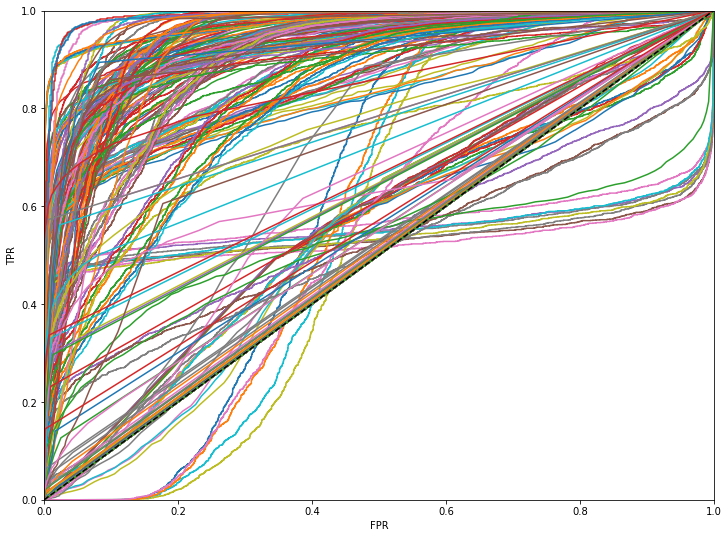


solo: 1


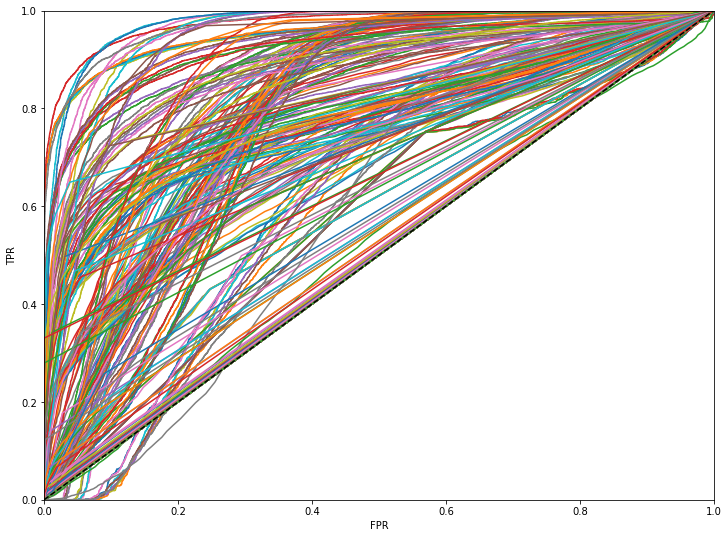


solo: 2


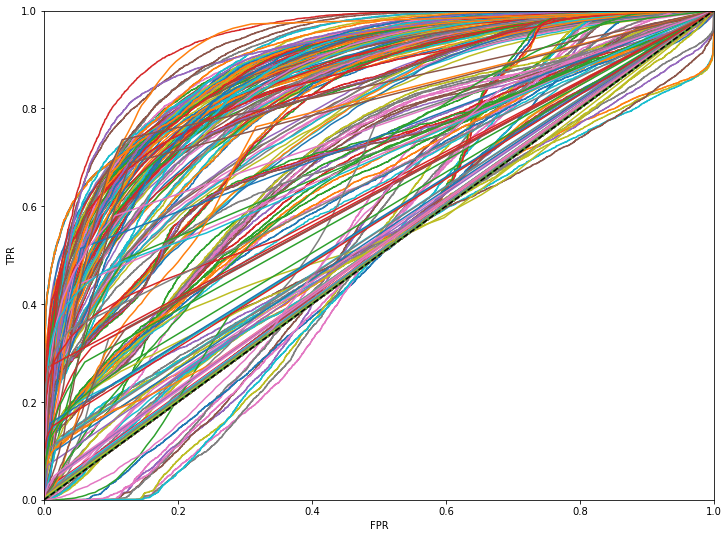

In [17]:
# Plot ROC curves for each soil for all columns
# and save AUC and MAc for each soil for all columns in two separate dataframes

scores_auc = pd.DataFrame(None, columns = [0, 1, 2], index=data.columns)
scores_mac = pd.DataFrame(None, columns = [0, 1, 2], index=data.columns)
for soil in range(3):
    plt.figure(figsize=(12,9))
    print("\nsolo:", soil)
    
    for col in data.columns:
        score = roc_auc_score(y.loc[solo == soil], data.loc[solo == soil][col])
        fpr, tpr, th = roc_curve(y.loc[solo == soil], data.loc[solo == soil][col])
        if score < .5:
            fpr, tpr = tpr, fpr
            score = 1 - score
        mean_acc, _ = getBestTreshold(fpr, tpr, th)

        scores_auc.loc[col, soil] = score
        scores_mac.loc[col, soil] = mean_acc

        #print(" > %-30s AUC = %.3f \t MeanAcc = %.3f" % (col, score, mean_acc))
        plt.plot(fpr, tpr)

    plt.ylim((0,1))
    plt.xlim((0,1))
    plt.plot([0,1], [0,1], "k--")
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.show()


In [18]:
scores_mac["amean"] = scores_mac[[0,1,2]].mean(axis=1)
scores_mac["min"] = scores_mac[[0,1,2]].min(axis=1)
#scores_mac["gmean"] = np.power(scores_mac[[0,1,2]].prod(axis=1) , 1/3)

In [20]:
best_features = scores_mac.sort_values("min", ascending=False)[[0,1,2]].iloc[:10]
# pyperclip.copy(best_features.to_latex())
best_features

,0,1,2
NGRDI_mean,0.931323,0.87401,0.842153
ExGR_max,0.921656,0.873789,0.839155
NGRDI_max,0.898999,0.834825,0.86316
border_5,0.874346,0.825674,0.850489
ExGR_mean,0.950861,0.903677,0.812371
CIVE_correlation_np.pi/4,0.897944,0.838812,0.809736
border_9,0.920497,0.87435,0.809619
VEG_max,0.930035,0.89014,0.807138
CIVE_correlation_3*np.pi/2,0.886885,0.842852,0.804194
CIVE_correlation_7*np.pi/4,0.896399,0.856847,0.801042


In [12]:
cols = scores_mac.sort_values("min", ascending=False)[[0,1,2]].iloc[:10].index
plt.figure(figsize=(16,5))
for soil in range(3):
    plt.subplot(1,3,soil+1)
    
    for col in cols:
        score = roc_auc_score(y.loc[solo == soil], data.loc[solo == soil][col])
        fpr, tpr, th = roc_curve(y.loc[solo == soil], data.loc[solo == soil][col])
        if score < .5:
            fpr, tpr = tpr, fpr
            score = 1 - score
            
        #print(" > %-30s AUC = %.3f \t MeanAcc = %.3f" % (col, score, mean_acc))
        plt.plot(fpr, tpr, label = col)
    plt.title("Solo %d" % soil)
    plt.ylim((0,1))
    plt.xlim((0,1))
    plt.plot([0,1], [0,1], "k--")
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.legend(loc = 4)
# plt.savefig("report1/figures/10bestminfeatures.png")

NameError: name 'scores_mac' is not defined

In [141]:
scores_mac.sort_values(2, ascending=False)[2].iloc[:10]

NGRDI_max      0.86316
NGRDI_mean    0.842153
ExGR_max      0.839155
NGRDI_std     0.824134
ExGR_std      0.823302
VEG_std       0.813944
ExGR_mean     0.812371
VEG_max       0.807138
CIVE_std      0.804727
ExG_std       0.801579
Name: 2, dtype: object

# 1) Check VI discriminant capability

### In this section, we check the AUC, Mean Accuracy and ROC curves for each VI in each soil type (0, 1, 2)

In [12]:
names_VI = ["ExG", "ExGR", "CIVE", "VEG", "WI", "NGRDI"]

In [13]:
VI_cols = [name + "_mean" for name in names_VI]

In [14]:
# Get only columns with mean of VI values of 16x16 regions
VI_data = data[[name + "_mean" for name in names_VI]]

In [15]:
"""
for each generalization test:
    separate into test and rest (how many times?)
    separate rest into train and val (how many times?)
    find best th value and best VI (which mean: keep the VI used and the TH.
        > maybe save all in a table and then order it
    test the best
"""

'\nfor each generalization test:\n    separate into test and rest (how many times?)\n    separate rest into train and val (how many times?)\n    find best th value and best VI (which mean: keep the VI used and the TH.\n        > maybe save all in a table and then order it\n    test the best\n'

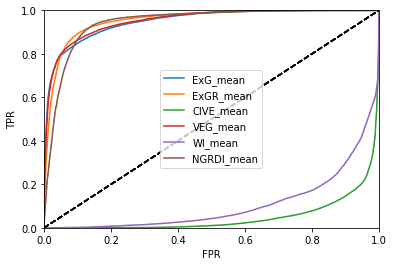

In [16]:
for col in VI_cols:
    fpr, tpr, th = roc_curve(y, data[col])
    
    plt.plot(fpr, tpr, label = col)
    plt.ylim((0,1))
    plt.xlim((0,1))
    plt.plot([0,1], [0,1], "k--")
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.legend()

In [17]:
data['CIVE_mean'] = 1 - data['CIVE_mean']
data['WI_mean'] = 1 - data['WI_mean']

In [24]:
data['block'] = BLOCK
data['img'] = IMG

In [25]:
len(data.block.unique())

1024

In [26]:
32 * 32

1024

In [113]:
neigh = [-32 - 1, -32, -32 + 1, -1, +1, +32 - 1, +32, +32 + 1]
suf = [chr(ord('B') + i) for i in range(8)]
suf

['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

In [114]:
d = data.copy()
d.columns = [col + 'A' if col not in {'block', 'img'} else col for col in d.columns]

In [115]:
for n, s in zip(neigh, suf):
    temp = data.copy()
    temp.columns = [col + s if col not in {'block', 'img'} else col for col in temp.columns]
    temp['block'] += n
    d = pd.merge(d, temp, on = ['img', 'block'], how = 'left')
    

In [116]:
del d['block']
del d['img']

In [142]:
cg = dict()
for col in d.columns:
    if col[:-1] in cg:
        cg[col[:-1]].append(col)
    else:
        cg[col[:-1]] = [col]
len(cg)

314

In [149]:
f = data.copy()
f.shape

(60416, 316)

In [150]:
for g, cols in cg.items():
    f[g + '_area_mean'] = d[cols].mean(axis = 1) 
# for g, cols in cg.items():
#     f[g + '_area_std'] = d[cols].std(axis = 1)
# for g, cols in cg.items():
#     f[g + '_area_max'] = d[cols].max(axis = 1) 

In [151]:
f.shape

(60416, 630)

In [152]:
del f['block']
del f['img']

In [153]:
f.fillna(-999999, inplace= True)

In [156]:
def XGBTrain(data, train_imgs, val_imgs, y):

    X_train, y_train = data.loc[IMG.isin(train_imgs)], y.loc[IMG.isin(train_imgs)]
    X_val, y_val = data.loc[IMG.isin(val_imgs)], y.loc[IMG.isin(val_imgs)]
    
    ratio = float(np.sum(y_train == 1)) / np.sum(y_train==0)

    clf = xgb.XGBClassifier(
        missing = -999999,
                    max_depth = 4,
                    n_estimators=1000,
                    learning_rate=0.2, 
                    nthread=3,
                    subsample=1.0,
                    colsample_bytree=1,
                    scale_pos_weight = ratio,
                    reg_alpha=0.0,
                    seed=0)

    clf.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
            eval_set=[(X_val, y_val)], verbose = False)
    
    return clf

In [157]:
reps = 5
auc_matrix = np.zeros((4, reps))
auc_matrix_val = np.zeros((4, reps))
mac_matrix = np.zeros((4, reps))
mac_matrix_val = np.zeros((4, reps))
clfs = [[None] * reps] * 4 # 4 is the number of experiments

for e, (left, test) in enumerate(experiments):
    print("Experiment", left, test)
    Xleft = f.loc[solo.isin(left)]
    Xtest = f.loc[solo.isin(test)]
    
    
    for i, (train_imgs, val_imgs) in enumerate(splitByImages(Xleft, 1/4, reps)):
        # train
        clf = XGBTrain(f, train_imgs, val_imgs, y)
        
        # get val performance of this trained model: ROC, AUC and MAc, and also the best threshold value for test
        prediction = clf.predict_proba(f.loc[IMG.isin(val_imgs)])[:,-1]
        val_auc, val_mean_acc, bestTH, fpr, tpr = getPerformance(y.loc[IMG.isin(val_imgs)], prediction)
        
        # get train either?
        
        # get test performance
        prediction = clf.predict_proba(f.loc[solo.isin(test)])[:,-1]
        mean_acc = accuracy_score(y.loc[solo.isin(test)], 1 * (prediction > bestTH)) # 1 * array = array.astype(int)
        
               
        # save performance
        mac_matrix[e, i] = mean_acc
        mac_matrix_val[e, i] = val_mean_acc
        
        auc_matrix_val[e, i] = clf.best_score
        
        # save classifiers for further analysis
        clfs[e][i] = [clf, left, test, bestTH]
        
        print(" > %d iterations \t Val vs Test (MAc) = %.3f vs %.3f" % (clf.best_iteration, 
                                                                               val_mean_acc, mean_acc))
        
print("Done.")   

Experiment [0] [1]
 > 19 iterations 	 Val vs Test (MAc) = 0.930 vs 0.696
 > 24 iterations 	 Val vs Test (MAc) = 0.951 vs 0.665
 > 46 iterations 	 Val vs Test (MAc) = 0.965 vs 0.807
 > 16 iterations 	 Val vs Test (MAc) = 0.980 vs 0.778
 > 48 iterations 	 Val vs Test (MAc) = 0.975 vs 0.708
Experiment [1] [0]
 > 26 iterations 	 Val vs Test (MAc) = 0.941 vs 0.957
 > 27 iterations 	 Val vs Test (MAc) = 0.917 vs 0.960
 > 40 iterations 	 Val vs Test (MAc) = 0.917 vs 0.964
 > 24 iterations 	 Val vs Test (MAc) = 0.924 vs 0.958
 > 63 iterations 	 Val vs Test (MAc) = 0.912 vs 0.956
Experiment [0, 1] [2]
 > 47 iterations 	 Val vs Test (MAc) = 0.932 vs 0.715
 > 59 iterations 	 Val vs Test (MAc) = 0.931 vs 0.728
 > 27 iterations 	 Val vs Test (MAc) = 0.955 vs 0.761
 > 30 iterations 	 Val vs Test (MAc) = 0.947 vs 0.715
 > 36 iterations 	 Val vs Test (MAc) = 0.956 vs 0.724
Experiment [2] [0, 1]
 > 43 iterations 	 Val vs Test (MAc) = 0.940 vs 0.925
 > 49 iterations 	 Val vs Test (MAc) = 0.919 vs 0.922


In [49]:
from sklearn.model_selection import LeaveOneOut

In [50]:
loo = LeaveOneOut()

In [53]:
for a in loo.split([1, 2, 3]):
    print(a)

(array([1, 2]), array([0]))
(array([0, 2]), array([1]))
(array([0, 1]), array([2]))


In [57]:
IMG.value_counts()

39.0    1024
61.0    1024
23.0    1024
22.0    1024
51.0    1024
58.0    1024
33.0    1024
40.0    1024
7.0     1024
9.0     1024
10.0    1024
49.0    1024
47.0    1024
54.0    1024
29.0    1024
37.0    1024
18.0    1024
43.0    1024
38.0    1024
50.0    1024
57.0    1024
1.0     1024
3.0     1024
0.0     1024
8.0     1024
16.0    1024
4.0     1024
2.0     1024
36.0    1024
31.0    1024
46.0    1024
45.0    1024
53.0    1024
13.0    1024
27.0    1024
60.0    1024
35.0    1024
21.0    1024
14.0    1024
5.0     1024
44.0    1024
28.0    1024
59.0    1024
19.0    1024
15.0    1024
42.0    1024
25.0    1024
26.0    1024
34.0    1024
41.0    1024
48.0    1024
6.0     1024
52.0    1024
24.0    1024
56.0    1024
12.0    1024
17.0    1024
55.0    1024
32.0    1024
Name: img_num, dtype: int64

In [60]:
df = pd.DataFrame({'img' : IMG , 'solo' : solo})

In [61]:
df.groupby('img')['solo'].nunique()

img
0.0     1
1.0     1
2.0     1
3.0     1
4.0     1
5.0     1
6.0     1
7.0     1
8.0     1
9.0     1
10.0    1
12.0    1
13.0    1
14.0    1
15.0    1
16.0    1
17.0    1
18.0    1
19.0    1
21.0    1
22.0    1
23.0    1
24.0    1
25.0    1
26.0    1
27.0    1
28.0    1
29.0    1
31.0    1
32.0    1
33.0    1
34.0    1
35.0    1
36.0    1
37.0    1
38.0    1
39.0    1
40.0    1
41.0    1
42.0    1
43.0    1
44.0    1
45.0    1
46.0    1
47.0    1
48.0    1
49.0    1
50.0    1
51.0    1
52.0    1
53.0    1
54.0    1
55.0    1
56.0    1
57.0    1
58.0    1
59.0    1
60.0    1
61.0    1
Name: solo, dtype: int64

In [58]:
reps = 5
mac_matrix = np.zeros((4, reps))
VI_scores = [{name + "_mean" : [] for name in names_VI}] * 4 # 4 is the number of experiments
VI_scores_val = [{name + "_mean" : [] for name in names_VI}] * 4

for e, (left, test) in enumerate(experiments):
    print("Experiment", left, test)
    Xleft = data.loc[solo.isin(left)]
    Xtest = data.loc[solo.isin(test)]
    
    images = list(set(IMG.loc[Xleft.index]))
    for col in VI_cols:
#         a = splitByImages(Xleft, 1/4, 6)
#         train_imgs, test_imgs = next(a)
        print('>', col)
        
        
        # for train_imgs, test_imgs in splitByImages(Xleft, 1/4, 6):
        for train_imgs, test_imgs in loo.split(images):

            # get val performance of this trained model: ROC, AUC and MAc, and also the best threshold value for test
    #         prediction = Xleft[col]
            prediction = Xleft.loc[IMG.isin(train_imgs), col]
            print(len(prediction), len(y.loc[solo.isin(left) & IMG.isin(train_imgs)]))
            val_auc, val_mean_acc, bestTH, fpr, tpr = getPerformance(y.loc[IMG.isin(train_imgs)], prediction)


            # get test performance
    #         prediction = Xtest[col]
            prediction = Xleft.loc[IMG.isin(test_imgs), col]
            mean_acc = accuracy_score(y.loc[IMG.isin(test_imgs)], 1 * (prediction > bestTH)) # 1 * array = array.astype(int)
    #         if col in ["CIVE_mean"]:
    #             mean_acc = accuracy_score(y.loc[solo.isin(test)], 1 * (prediction < bestTH))


            # save performance
            VI_scores[e][col].append(mean_acc)
            VI_scores_val[e][col].append(val_mean_acc)
            print(" > > %s \t Val vs Test (MAc) = %.3f vs %.3f" % (col, val_mean_acc, mean_acc))
        
        
        
print("Done.")    

Experiment [0] [1]
> ExG_mean
15360 15360
 > > ExG_mean 	 Val vs Test (MAc) = 0.959 vs 0.997
15360 15360
 > > ExG_mean 	 Val vs Test (MAc) = 0.960 vs 0.987
15360 15360
 > > ExG_mean 	 Val vs Test (MAc) = 0.966 vs 0.864
15360 15360
 > > ExG_mean 	 Val vs Test (MAc) = 0.961 vs 0.943
15360 15360
 > > ExG_mean 	 Val vs Test (MAc) = 0.962 vs 0.971
15360 15360
 > > ExG_mean 	 Val vs Test (MAc) = 0.960 vs 0.978
15360 15360
 > > ExG_mean 	 Val vs Test (MAc) = 0.960 vs 0.973
15360 15360
 > > ExG_mean 	 Val vs Test (MAc) = 0.957 vs 0.947
15360 15360
 > > ExG_mean 	 Val vs Test (MAc) = 0.963 vs 0.888
15360 15360
 > > ExG_mean 	 Val vs Test (MAc) = 0.960 vs 0.989
15360 15360
 > > ExG_mean 	 Val vs Test (MAc) = 0.954 vs 0.975
16384 16384
 > > ExG_mean 	 Val vs Test (MAc) = 0.961 vs nan
15360 15360
 > > ExG_mean 	 Val vs Test (MAc) = 0.960 vs 0.991
15360 15360


/store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 > > ExG_mean 	 Val vs Test (MAc) = 0.966 vs 0.934
15360 15360
 > > ExG_mean 	 Val vs Test (MAc) = 0.959 vs 0.999
15360 15360
 > > ExG_mean 	 Val vs Test (MAc) = 0.961 vs 0.987
15360 15360
 > > ExG_mean 	 Val vs Test (MAc) = 0.959 vs 0.929
> ExGR_mean
15360 15360
 > > ExGR_mean 	 Val vs Test (MAc) = 0.950 vs 0.991
15360 15360
 > > ExGR_mean 	 Val vs Test (MAc) = 0.952 vs 0.988
15360 15360
 > > ExGR_mean 	 Val vs Test (MAc) = 0.959 vs 0.856
15360 15360
 > > ExGR_mean 	 Val vs Test (MAc) = 0.952 vs 0.951
15360 15360
 > > ExGR_mean 	 Val vs Test (MAc) = 0.954 vs 0.963
15360 15360
 > > ExGR_mean 	 Val vs Test (MAc) = 0.951 vs 0.974
15360 15360
 > > ExGR_mean 	 Val vs Test (MAc) = 0.951 vs 0.967
15360 15360
 > > ExGR_mean 	 Val vs Test (MAc) = 0.947 vs 0.925
15360 15360
 > > ExGR_mean 	 Val vs Test (MAc) = 0.953 vs 0.921
15360 15360
 > > ExGR_mean 	 Val vs Test (MAc) = 0.951 vs 0.984
15360 15360
 > > ExGR_mean 	 Val vs Test (MAc) = 0.939 vs 0.967
16384 16384
 > > ExGR_mean 	 Val vs Test (MA

/store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 > > ExGR_mean 	 Val vs Test (MAc) = 0.951 vs 0.976
15360 15360
 > > ExGR_mean 	 Val vs Test (MAc) = 0.957 vs 0.929
15360 15360
 > > ExGR_mean 	 Val vs Test (MAc) = 0.950 vs 0.995
15360 15360
 > > ExGR_mean 	 Val vs Test (MAc) = 0.953 vs 0.974
15360 15360
 > > ExGR_mean 	 Val vs Test (MAc) = 0.948 vs 0.940
> CIVE_mean
15360 15360
 > > CIVE_mean 	 Val vs Test (MAc) = 0.959 vs 0.997
15360 15360
 > > CIVE_mean 	 Val vs Test (MAc) = 0.960 vs 0.988
15360 15360
 > > CIVE_mean 	 Val vs Test (MAc) = 0.966 vs 0.868
15360 15360
 > > CIVE_mean 	 Val vs Test (MAc) = 0.961 vs 0.946
15360 15360
 > > CIVE_mean 	 Val vs Test (MAc) = 0.961 vs 0.971
15360 15360
 > > CIVE_mean 	 Val vs Test (MAc) = 0.959 vs 0.981
15360 15360
 > > CIVE_mean 	 Val vs Test (MAc) = 0.960 vs 0.973
15360 15360
 > > CIVE_mean 	 Val vs Test (MAc) = 0.957 vs 0.947
15360 15360
 > > CIVE_mean 	 Val vs Test (MAc) = 0.963 vs 0.895
15360 15360
 > > CIVE_mean 	 Val vs Test (MAc) = 0.960 vs 0.990
15360 15360
 > > CIVE_mean 	 Val vs Test

/store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 > > CIVE_mean 	 Val vs Test (MAc) = 0.960 vs nan
15360 15360
 > > CIVE_mean 	 Val vs Test (MAc) = 0.960 vs 0.991
15360 15360
 > > CIVE_mean 	 Val vs Test (MAc) = 0.966 vs 0.938
15360 15360
 > > CIVE_mean 	 Val vs Test (MAc) = 0.959 vs 0.999
15360 15360
 > > CIVE_mean 	 Val vs Test (MAc) = 0.961 vs 0.987
15360 15360
 > > CIVE_mean 	 Val vs Test (MAc) = 0.958 vs 0.933
> VEG_mean
15360 15360
 > > VEG_mean 	 Val vs Test (MAc) = 0.959 vs 0.997
15360 15360
 > > VEG_mean 	 Val vs Test (MAc) = 0.960 vs 0.989
15360 15360
 > > VEG_mean 	 Val vs Test (MAc) = 0.967 vs 0.871
15360 15360
 > > VEG_mean 	 Val vs Test (MAc) = 0.961 vs 0.949
15360 15360
 > > VEG_mean 	 Val vs Test (MAc) = 0.962 vs 0.974
15360 15360
 > > VEG_mean 	 Val vs Test (MAc) = 0.959 vs 0.981
15360 15360
 > > VEG_mean 	 Val vs Test (MAc) = 0.960 vs 0.974
15360 15360
 > > VEG_mean 	 Val vs Test (MAc) = 0.957 vs 0.947
15360 15360
 > > VEG_mean 	 Val vs Test (MAc) = 0.963 vs 0.905
15360 15360
 > > VEG_mean 	 Val vs Test (MAc) = 0.96

/store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


15360 15360
 > > WI_mean 	 Val vs Test (MAc) = 0.908 vs 0.877
15360 15360
 > > WI_mean 	 Val vs Test (MAc) = 0.941 vs 0.702
16384 16384
 > > WI_mean 	 Val vs Test (MAc) = 0.908 vs nan
15360 15360
 > > WI_mean 	 Val vs Test (MAc) = 0.905 vs 0.949
15360 15360
 > > WI_mean 	 Val vs Test (MAc) = 0.912 vs 0.793
15360 15360
 > > WI_mean 	 Val vs Test (MAc) = 0.905 vs 0.938
15360 15360
 > > WI_mean 	 Val vs Test (MAc) = 0.903 vs 0.983
15360 15360
 > > WI_mean 	 Val vs Test (MAc) = 0.909 vs 0.779
> NGRDI_mean
15360 15360
 > > NGRDI_mean 	 Val vs Test (MAc) = 0.931 vs 0.990
15360 15360
 > > NGRDI_mean 	 Val vs Test (MAc) = 0.934 vs 0.979
15360 15360
 > > NGRDI_mean 	 Val vs Test (MAc) = 0.943 vs 0.869
15360 15360
 > > NGRDI_mean 	 Val vs Test (MAc) = 0.932 vs 0.960
15360 15360
 > > NGRDI_mean 	 Val vs Test (MAc) = 0.937 vs 0.945
15360 15360
 > > NGRDI_mean 	 Val vs Test (MAc) = 0.932 vs 0.962
15360 15360
 > > NGRDI_mean 	 Val vs Test (MAc) = 0.934 vs 0.947
15360 15360


/store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 > > NGRDI_mean 	 Val vs Test (MAc) = 0.925 vs 0.906
15360 15360
 > > NGRDI_mean 	 Val vs Test (MAc) = 0.933 vs 0.943
15360 15360
 > > NGRDI_mean 	 Val vs Test (MAc) = 0.933 vs 0.981
15360 15360
 > > NGRDI_mean 	 Val vs Test (MAc) = 0.913 vs 0.951
16384 16384
 > > NGRDI_mean 	 Val vs Test (MAc) = 0.933 vs nan
15360 15360
 > > NGRDI_mean 	 Val vs Test (MAc) = 0.933 vs 0.963
15360 15360
 > > NGRDI_mean 	 Val vs Test (MAc) = 0.939 vs 0.925
15360 15360
 > > NGRDI_mean 	 Val vs Test (MAc) = 0.931 vs 0.990
15360 15360
 > > NGRDI_mean 	 Val vs Test (MAc) = 0.935 vs 0.959
15360 15360
 > > NGRDI_mean 	 Val vs Test (MAc) = 0.927 vs 0.934
Experiment [1] [0]
> ExG_mean
2048 2048


/store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: Found input variables with inconsistent numbers of samples: [18432, 2048]

In [46]:
[max(r.keys(), key = lambda x : r[x]) for r in  VI_scores_val]

['NGRDI_mean', 'NGRDI_mean', 'NGRDI_mean', 'NGRDI_mean']

In [25]:
a = splitByImages(Xleft, 1/4, 1)

In [31]:
b = iter(a)

TypeError: 'code' object is not callable

In [15]:
def XGBTrain(data, train_imgs, val_imgs, y):

    X_train, y_train = data.loc[IMG.isin(train_imgs)], y.loc[IMG.isin(train_imgs)]
    X_val, y_val = data.loc[IMG.isin(val_imgs)], y.loc[IMG.isin(val_imgs)]
    
    ratio = float(np.sum(y_train == 1)) / np.sum(y_train==0)

    clf = xgb.XGBClassifier(
                    max_depth = 4,
                    n_estimators=1000,
                    learning_rate=0.1, 
                    nthread=3,
                    subsample=1.0,
                    colsample_bytree=1,
                    scale_pos_weight = ratio,
                    reg_alpha=0.03,
                    seed=1301)

    clf.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
            eval_set=[(X_val, y_val)], verbose = False)
    
    return clf

In [17]:
reps = 30
auc_matrix = np.zeros((4, reps))
auc_matrix_val = np.zeros((4, reps))
mac_matrix = np.zeros((4, reps))
mac_matrix_val = np.zeros((4, reps))
clfs = [[None] * reps] * 4 # 4 is the number of experiments

for e, (left, test) in enumerate(experiments):
    print("Experiment", left, test)
    Xleft = data.loc[solo.isin(left)]
    Xtest = data.loc[solo.isin(test)]
    
    
    for i, (train_imgs, val_imgs) in enumerate(splitByImages(Xleft, 1/4, reps)):
        # train
        clf = XGBTrain(data, train_imgs, val_imgs, y)
        
        # get val performance of this trained model: ROC, AUC and MAc, and also the best threshold value for test
        prediction = clf.predict_proba(data.loc[IMG.isin(val_imgs)])[:,-1]
        val_auc, val_mean_acc, bestTH, fpr, tpr = getPerformance(y.loc[IMG.isin(val_imgs)], prediction)
        
        # get train either?
        
        # get test performance
        prediction = clf.predict_proba(data.loc[solo.isin(test)])[:,-1]
        mean_acc = accuracy_score(y.loc[solo.isin(test)], 1 * (prediction > bestTH)) # 1 * array = array.astype(int)
        
               
        # save performance
        mac_matrix[e, i] = mean_acc
        mac_matrix_val[e, i] = val_mean_acc
        
        auc_matrix_val[e, i] = clf.best_score
        
        # save classifiers for further analysis
        clfs[e][i] = [clf, left, test, bestTH]
        
        print(" > %d iterations \t Val vs Test (MAc) = %.3f vs %.3f" % (clf.best_iteration, 
                                                                               val_mean_acc, mean_acc))
        
print("Done.")    

Experiment [0] [1]
 > 60 iterations 	 Val vs Test (MAc) = 0.975 vs 0.855
 > 29 iterations 	 Val vs Test (MAc) = 0.944 vs 0.818
 > 108 iterations 	 Val vs Test (MAc) = 0.958 vs 0.761
 > 92 iterations 	 Val vs Test (MAc) = 0.940 vs 0.727
 > 86 iterations 	 Val vs Test (MAc) = 0.981 vs 0.834
 > 99 iterations 	 Val vs Test (MAc) = 0.962 vs 0.703
 > 81 iterations 	 Val vs Test (MAc) = 0.961 vs 0.761
 > 20 iterations 	 Val vs Test (MAc) = 0.972 vs 0.792
 > 105 iterations 	 Val vs Test (MAc) = 0.965 vs 0.589
 > 46 iterations 	 Val vs Test (MAc) = 0.959 vs 0.802
 > 73 iterations 	 Val vs Test (MAc) = 0.909 vs 0.564
 > 54 iterations 	 Val vs Test (MAc) = 0.957 vs 0.792
 > 31 iterations 	 Val vs Test (MAc) = 0.984 vs 0.881
 > 44 iterations 	 Val vs Test (MAc) = 0.976 vs 0.841
 > 79 iterations 	 Val vs Test (MAc) = 0.963 vs 0.734
 > 101 iterations 	 Val vs Test (MAc) = 0.977 vs 0.729
 > 87 iterations 	 Val vs Test (MAc) = 0.918 vs 0.675
 > 88 iterations 	 Val vs Test (MAc) = 0.978 vs 0.787
 > 41 

In [20]:
mac_matrix.mean(axis = 1), mac_matrix.std(axis = 1),

(array([0.749611  , 0.95229396, 0.73437796, 0.91719806]),
 array([0.09077009, 0.01543022, 0.01782041, 0.01536982]))

In [21]:
mac_matrix_val.mean(axis = 1), mac_matrix_val.std(axis = 1),

(array([0.95752541, 0.92350273, 0.93413116, 0.87843074]),
 array([0.02203235, 0.01451363, 0.01129092, 0.04790362]))

# Análise do Resultados

In [45]:
clf_ind = 2 # base 2 out is better to find out why training in 0 and 1 fail in generalizing to 2
clf, left, test, bestTH = clfs[clf_ind][0]

X_train, y_train = data.loc[solo.isin(left)], y.loc[solo.isin(left)]
X_test, y_test = data.loc[solo.isin(test)], y.loc[solo.isin(test)]

predict = clf.predict_proba(X_test, ntree_limit=clf.best_iteration)[:,-1]

In [41]:
from skimage.util.shape import view_as_blocks
from skimage.io import imread


In [55]:
paths = pd.read_csv('../IC2017_DATA/valid_images.csv', index_col=0)
n_images = len(paths)

In [83]:
paths['base_num'] = 1
paths.loc[paths.index <= 17, 'base_num'] = 0
paths.loc[paths.index >= 40, 'base_num'] = 2

In [84]:
paths

,pic,gt,base_num
num,,,
0,../IC2017_DATA/suborbitalRS_40_check/pictures/...,../IC2017_DATA/suborbitalRS_40_check/gts/gt01.png,0
1,../IC2017_DATA/suborbitalRS_40_check/pictures/...,../IC2017_DATA/suborbitalRS_40_check/gts/gt02.png,0
2,../IC2017_DATA/suborbitalRS_40_check/pictures/...,../IC2017_DATA/suborbitalRS_40_check/gts/gt03.png,0
3,../IC2017_DATA/suborbitalRS_40_check/pictures/...,../IC2017_DATA/suborbitalRS_40_check/gts/gt04.png,0
4,../IC2017_DATA/suborbitalRS_40_check/pictures/...,../IC2017_DATA/suborbitalRS_40_check/gts/gt05.png,0
5,../IC2017_DATA/suborbitalRS_40_check/pictures/...,../IC2017_DATA/suborbitalRS_40_check/gts/gt06.png,0
6,../IC2017_DATA/suborbitalRS_40_check/pictures/...,../IC2017_DATA/suborbitalRS_40_check/gts/gt07.png,0
7,../IC2017_DATA/suborbitalRS_40_check/pictures/...,../IC2017_DATA/suborbitalRS_40_check/gts/gt08.png,0
8,../IC2017_DATA/suborbitalRS_40_check/pictures/...,../IC2017_DATA/suborbitalRS_40_check/gts/gt09.png,0


In [48]:
th = bestTH

# m1 = ((y_test == 1) & (prediction < th))
# m0 = ((y_test == 0) & (prediction > th))

pred_all = clf.predict_proba(data, ntree_limit=clf.best_iteration)[:,-1]
m1 = ((y == 1) & (pred_all < th))
m0 = ((y == 0) & (pred_all >= th))

m1.sum(), m0.sum()

(2134, 2652)

In [50]:
misses = pd.concat([IMG[m0].value_counts().rename("NOVEG-miss"), IMG[m1].value_counts().rename("VEG-miss")], axis = 1).fillna(0)

In [51]:
misses["sum"] = misses["NOVEG-miss"] + misses["VEG-miss"]

In [52]:
misses.sort_values("sum",ascending=False)

,NOVEG-miss,VEG-miss,sum
52.0,85.0,135.0,220.0
40.0,59.0,121.0,180.0
50.0,143.0,35.0,178.0
18.0,111.0,66.0,177.0
27.0,111.0,59.0,170.0
24.0,150.0,16.0,166.0
59.0,70.0,81.0,151.0
19.0,93.0,58.0,151.0
32.0,100.0,49.0,149.0
25.0,53.0,93.0,146.0


In [57]:
def highlight(ind, color):
    x_ini = (ind % 32) * 16
    x_end = x_ini + 15
    y_ini = (ind // 32) * 16
    y_end = y_ini + 15
    plt.fill_between([x_ini, x_end], y_ini, y_end, alpha =.4, color = color)

In [1]:

# for i in paths.query('base_num == 2').index:
for i in paths.index:
    pic = imread(paths.loc[i, 'pic'], as_gray = False)
    gt = imread(paths.loc[i, 'gt'], as_gray = True)

    plt.figure(figsize=(16,7), dpi = 200)
    plt.subplots_adjust(wspace = 0, hspace = 0)

    plt.subplot(1,2,1)
    plt.imshow(pic)
    for b in BLOCK[(IMG == i) & m1]:
        highlight(b, "red")
    for b in BLOCK[(IMG == i) & m0]:
        highlight(b, "blue")
    plt.ylim((511,0))
    plt.xlim((0,511))
    plt.yticks([])
    plt.xticks([])

    plt.subplot(1,2,2)
    plt.imshow(gt)
    for b in BLOCK[(IMG == i) & (y == 1)]:
        highlight(b, "green")
    plt.ylim((511,0))
    plt.xlim((0,511))
    plt.yticks([])
    plt.xticks([])

    plt.savefig('report/misses_%02d.pdf' % i, format = 'pdf', dpi = 200)
    print(i)
    plt.show()

NameError: name 'paths' is not defined